In [1]:
import numpy as np
import pandas as pd
import unicodedata,re,math,random
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 加载数据集

In [2]:
train_df = pd.read_csv('train.tsv', sep = '\t')

## 显示数据集的信息

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


## 对数据集作描述性分析

In [4]:
train_df.describe()    

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


# 查看评分的类别分布

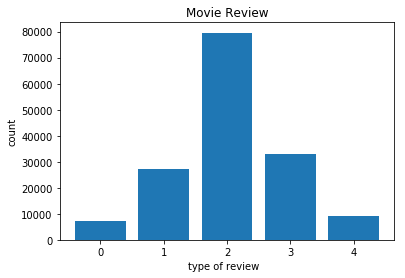

In [5]:
uniqueLabel=set(train_df['Sentiment'])
x=[]
y=[]
for i in uniqueLabel:
    x.append(i)
    y.append(train_df['Sentiment'][train_df['Sentiment']==i].size)
plt.figure(111)
plt.bar(x,y)
plt.xlabel('type of review  ')
plt.ylabel('count')
plt.title('Movie Review')
plt.show()

# 预处理

In [6]:
# 第一步，定义对数据规范化的函数
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

#将数据集中的word全部小写
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

#去除标点符号
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#去除数据集中的数字
def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#去除停用词
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and len(word)>1:
            new_words.append(word)
    return new_words

#整合上面的所有定义函数到该函数，来规范化数据
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

## 切分Phrase

In [7]:
#第二步，tokenize Phrase
train_df['Words'] = train_df['Phrase'].apply(nltk.word_tokenize)
train_df['Words'].head()

0    [A, series, of, escapades, demonstrating, the,...
1    [A, series, of, escapades, demonstrating, the,...
2                                          [A, series]
3                                                  [A]
4                                             [series]
Name: Words, dtype: object

In [8]:
# 第三步 - 应用之前定义的函数
train_df['Words'] = train_df['Words'].apply(normalize) 
train_df['Words'].head()

0    [series, escapades, demonstrating, adage, good...
1    [series, escapades, demonstrating, adage, good...
2                                             [series]
3                                                   []
4                                             [series]
Name: Words, dtype: object

In [9]:
# 第三步 - 创建要用作编码字典的唯一单词列表
word_set = set()
for l in train_df['Words']:
    for word in l:
        word_set.add(word)
        
word_to_int = {word: i for i, word in enumerate(word_set, 1)}

# 检查两者长度是否一致
print(len(word_set))
print(len(word_to_int))

16060
16060


In [10]:
# 根据word_to_int去标记每个word
train_df['Tokens'] = train_df['Words'].apply(lambda l: [word_to_int[word] for word in l])
train_df['Tokens'].head()

0    [3600, 14627, 14006, 3553, 2215, 14682, 9712, ...
1              [3600, 14627, 14006, 3553, 2215, 14682]
2                                               [3600]
3                                                   []
4                                               [3600]
Name: Tokens, dtype: object

In [11]:
# 第四步，获取句子的最长长度
max_len = train_df['Tokens'].str.len().max()
print(max_len)

30


In [12]:
all_tokens = np.array([t for t in train_df['Tokens']])
encoded_labels = np.array([l for l in train_df['Sentiment']])

# 创建数据集长度×最长句子长度的零矩阵
features = np.zeros((len(all_tokens), max_len), dtype=int)
# 对于每个句子，用0补齐维度到max_len
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#打印出特征矩阵的前三行 
print(features[:3])

[[ 3600 14627 14006  3553  2215 14682  9712  2215 10302  7493 14584  5219
   9128   945 10762     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 3600 14627 14006  3553  2215 14682     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 3600     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]


### 切分data 为训练集、验证集和测试集

In [13]:
train_x,remaing_x,train_y,remaing_y = train_test_split(features,encoded_labels,test_size=0.2,random_state=3)
val_x,test_x,val_y,test_y = train_test_split(remaing_x, remaing_y,test_size=0.5)
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
     "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(124848, 30) 
Validation set: 	(15606, 30) 
Test set: 		(15606, 30)


## DataLoaders和批处理

1）创建一种用于访问数据的已知格式，使用TensorDataset接收输入数据集和具有相同第一维的目标数据集，并创建数据集。

2）创建DataLoaders并批量训练，验证Tensor数据集。

In [14]:
# 创建Tensor数据集
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# 数据载入
batch_size = 54

# 确保shuffle你的数据集
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# 检查载入数据集的大小(有多少个batches)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

2312
289
289


## 创建深层网络

1）首先，我们将文字传递给嵌入层。我们需要一个嵌入层，因为我们有数千个单词，因此我们需要比单热编码向量更有效的输入数据表示。在这种情况下，嵌入层用于降低维数，而不是用于学习语义表示。

2）输入字传递到嵌入层后，新的嵌入将传递给LSTM单元。 LSTM单元将添加到网络的循环连接，并使我们能够包含有关电影评论数据中单词序列的信息。 LSTM接收input_size，hidden_​​dim，多个层，丢失概率（用于多个层之间的丢失）和batch_first参数。

3）最后，LSTM输出将进入线性层进行最终分类，其输出将被传递到交叉熵损失函数以获得每个预测类的概率。

层次如下：

嵌入层，用于将单词标记（整数）转换为特定大小的嵌入。

由hidden_state大小和层数定义的LSTM层

一个完全连接的输出层，用于将LSTM层输出映射到所需的output_size

稍后将通过Crossentropy损失函数应用softmax，其将所有输出转换为概率

大多数情况下，网络将具有更多层的更好性能; 2-3之间。 添加更多层允许网络学习真正复杂的关系。

In [15]:
# 首先检查GPU是否可用
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [16]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM 层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        # dropout层
        self.dropout = nn.Dropout(0.3)
        
        # linear层
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        # 将lstm输出转换为线性层的输入大小
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)        

        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # 创建两个大小为n_layers  x  batch_size  x  hidden_dim的新张量
        # 对于LSTM的隐藏状态和单元状态，初始化为零
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

##  Instantiate the network

在这里，我们将实例化网络。 首先，定义超参数。

vocab_size：我们词汇表的大小或我们输入的单词标记的值范围。

output_size：我们所需输出的大小; 我们想要输出的得分（0..4）。

embedding_dim：嵌入查找表中的列数; 嵌入的大小。

hidden_dim：LSTM单元隐藏层中的单元数。 通常更大是更好的性能。 常用值为128,256,512等。

n_layers：网络中LSTM层的数量。 通常在1-3之间

In [17]:
# 实例化模型（超参）
vocab_size = len(word_to_int)+1 # +1 for the 0 padding
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(16061, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


### 训练惯例

以下是典型的训练代码。 将使用Crossentropy损失，因为这是多类别分类问题。 我们还有一些数据和培训参数：

lr：我们的优化器的学习率。

epochs：迭代训练数据集的次数。

clip：要剪切的最大渐变值（以防止爆炸渐变）。

In [18]:
# 损失和优化函数
lr=0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [19]:
# 训练参数
epochs = 3 # 3-4 是经观察所得训练集损失停止减少的地方

counter = 0
print_every = 100
clip=5 #梯度裁剪

# 如果GPU可获得的话，把模型放到GPU上运行
if(train_on_gpu):
    net.cuda()

net.train()
# 训练一些epochs
for e in range(epochs):
    # 初始化隐藏状态
    h = net.init_hidden(batch_size)
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # 为隐藏状态创建新变量，否则
        # 我们通过整个训练历史过程进行反向传播
        h = tuple([each.data for each in h])

        # 优化之前，先将梯度归0
        net.zero_grad()

        # 从模型中得到输出结果
        output, h = net(inputs, h)
        # 计算损失和执行反向传播
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm`有助于防止RNN / LSTM中的爆炸梯度问题。
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # 损失数据
        if counter % print_every == 0:
            # 得到验证集损失
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 100... Loss: 1.165778... Val Loss: 1.296873
Epoch: 1/3... Step: 200... Loss: 1.446933... Val Loss: 1.293438
Epoch: 1/3... Step: 300... Loss: 1.182896... Val Loss: 1.287417
Epoch: 1/3... Step: 400... Loss: 1.184239... Val Loss: 1.288608
Epoch: 1/3... Step: 500... Loss: 1.295944... Val Loss: 1.290675
Epoch: 1/3... Step: 600... Loss: 1.355662... Val Loss: 1.288833
Epoch: 1/3... Step: 700... Loss: 1.175606... Val Loss: 1.290583
Epoch: 1/3... Step: 800... Loss: 1.250186... Val Loss: 1.288467
Epoch: 1/3... Step: 900... Loss: 1.259532... Val Loss: 1.286385
Epoch: 1/3... Step: 1000... Loss: 1.210624... Val Loss: 1.286427
Epoch: 1/3... Step: 1100... Loss: 1.125279... Val Loss: 1.284166
Epoch: 1/3... Step: 1200... Loss: 1.332783... Val Loss: 1.284108
Epoch: 1/3... Step: 1300... Loss: 1.115238... Val Loss: 1.268831
Epoch: 1/3... Step: 1400... Loss: 1.126952... Val Loss: 1.226120
Epoch: 1/3... Step: 1500... Loss: 1.208673... Val Loss: 1.224395
Epoch: 1/3... Step: 1600... Loss: 

## 测试

有几种方法可以测试神经网络能力：

测试数据性能：首先，我们将看到我们训练的模型如何在我们上面定义的所有test_data上执行。 我们将计算测试数据的平均损失和准确度。

对用户生成数据的推断：其次，我们将看看我们是否可以一次只输入一个示例评论（没有标签），并查看训练模型预测的内容。 查看这样的新用户输入数据并预测输出标签称为推理。
但是，对于该示例的实际目的，第二选项不适用，因为任务是对所提供短语的同步收集进行分类。

In [20]:
# 获取测试集的损失和准确率

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
#在test data迭代
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # 得到预测的结果
    output, h = net(inputs, h)
    # 计算损失
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # 将输出概率转换为预测类
    _, pred = torch.max(output,1)
    
    # 将预测值和真实label比较
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
#平均的测试损失
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# 整个测试集的准确率
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.907
Test accuracy: 0.630
